### Importando bibliotecas necessárias para o experimento

In [1]:
import os
import numpy as np
import pandas as pd

import lightning as L
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn.functional as F
import torch.nn.init as init

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns

### Carregando csv de treino, teste e validação

In [2]:
# testando amostras do professor
df_train = pd.read_csv('dataset/har-example-mo436/train.csv')
df_test = pd.read_csv('dataset/har-example-mo436/test.csv')
df_val = pd.read_csv('dataset/har-example-mo436/validation.csv')

df_train.drop(columns=[df_train.columns[0], 'gyro-end-time', 'level_0', 'accel-end-time', 'gyro-start-time', 'index', 'user', 'serial', 'accel-start-time', 'csv', 'timestamp diff', 'activity code', 'window'], inplace=True)
df_test.drop(columns=[df_train.columns[0], 'gyro-end-time', 'level_0', 'accel-end-time', 'gyro-start-time', 'index', 'user', 'serial', 'accel-start-time', 'csv', 'timestamp diff', 'activity code', 'window'], inplace=True)
df_val.drop(columns=[df_train.columns[0], 'gyro-end-time', 'level_0', 'accel-end-time', 'gyro-start-time', 'index', 'user', 'serial', 'accel-start-time', 'csv', 'timestamp diff', 'activity code', 'window'], inplace=True)

y_train = df_train.pop('standard activity code')
y_test = df_test.pop('standard activity code')
y_val = df_val.pop('standard activity code')

In [3]:
df_train.head()

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-50,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59
0,0.007964,-0.000341,-0.000917,0.013835,0.006055,-0.011637,0.021686,-0.022201,0.006096,-0.001330,...,-0.000271,0.000457,-0.000645,-0.000263,0.001054,-0.000839,0.000174,0.001233,0.001154,-0.001453
1,0.011350,0.000906,-0.017013,0.003416,-0.003677,0.003535,-0.013919,0.000987,-0.003978,-0.005770,...,-0.001686,-0.000034,0.000706,0.000902,-0.001349,-0.000159,0.001318,-0.002195,-0.000814,-0.003236
2,-0.011174,0.013523,-0.012778,-0.002615,0.019870,-0.026563,-0.001253,-0.012040,0.031816,0.011747,...,0.000840,0.000356,0.000121,-0.000329,-0.000464,-0.000249,-0.000191,0.000912,-0.000152,-0.000361
3,0.013647,0.025335,0.039625,0.032854,0.052418,0.019384,0.031342,0.014627,0.022141,0.052522,...,-0.002883,-0.001394,-0.004235,-0.004695,-0.004804,-0.004023,0.000290,-0.003753,-0.001526,-0.001583
4,0.003781,0.001663,-0.001938,0.011487,0.000006,-0.011932,0.015477,0.009142,-0.002724,0.010272,...,-0.000439,0.000336,-0.001660,-0.002663,-0.003443,-0.004423,0.000016,-0.002292,-0.002319,-0.003021


In [2]:
train_original = pd.read_csv('dataset/hars/train.csv')
df_test = pd.read_csv('dataset/hars/test.csv') # dataframe de teste

df_train, df_val = train_test_split(train_original, test_size=0.2, random_state=42) # dataframes de treino e validacao

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

# removendo coluna subject
df_train.drop(columns=['subject'], inplace=True)
df_test.drop(columns=['subject'], inplace=True)
df_val.drop(columns=['subject'], inplace=True)

# remapeando activity para seu respectivo valor numerivo
atividades = {
    'LAYING': 0, 
    'WALKING_UPSTAIRS': 1, 
    'STANDING': 2, 
    'WALKING': 3, 
    'SITTING': 4, 
    'WALKING_DOWNSTAIRS': 5
}
df_train['Activity'] = df_train['Activity'].map(atividades)
df_test['Activity'] = df_test['Activity'].map(atividades)
df_val['Activity'] = df_val['Activity'].map(atividades)

# Armazenar as colunas "Activity" removidas
y_train = df_train.pop('Activity')
y_test = df_test.pop('Activity')
y_val = df_val.pop('Activity')

print("shape train: ", df_train.shape)
print("shape test: ", df_test.shape)
print("shape valid: ", df_val.shape)

shape train:  (5881, 561)
shape test:  (2947, 561)
shape valid:  (1471, 561)


In [3]:
y_train.values

array([0, 1, 1, ..., 3, 2, 3])

In [4]:
df_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.278007,-0.017803,-0.108965,-0.994425,-0.994873,-0.994886,-0.994939,-0.993994,-0.995450,-0.938974,...,0.394506,-0.684497,-0.901888,0.751089,0.626432,0.263401,-0.646225,0.398881,-0.546717,-0.431200
1,0.237617,-0.000782,-0.114476,-0.326331,0.069663,-0.224321,-0.343326,0.039623,-0.256327,-0.310961,...,0.052089,-0.131946,-0.591721,0.628099,-0.357089,-0.925512,0.110212,-0.474013,0.383162,0.238969
2,0.290924,-0.050878,-0.073518,-0.026220,-0.032163,0.393109,-0.118256,-0.030279,0.432861,0.370607,...,-0.038923,-0.643660,-0.935668,-0.182993,0.484857,-0.961034,0.147325,-0.819001,0.221549,-0.003571
3,0.275268,-0.015050,-0.114204,-0.981092,-0.901124,-0.960423,-0.984417,-0.901405,-0.965788,-0.922291,...,-0.145084,-0.326860,-0.645937,0.205896,-0.168239,-0.197557,0.328892,-0.744428,0.274256,0.031246
4,0.278790,-0.018585,-0.106908,-0.997380,-0.983893,-0.984482,-0.997331,-0.985196,-0.983768,-0.942062,...,0.096524,-0.113724,-0.445144,-0.267371,-0.304399,-0.081555,0.110146,-0.615329,0.322236,0.161577


In [5]:
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(5881,)
(2947,)
(1471,)


### Feature Selection

In [6]:
# from sklearn.feature_selection import SelectKBest, f_classif

# # Selecionar 360 features mais relevantes
# selector = SelectKBest(f_classif, k=360)
# fs_train = selector.fit_transform(df_train.values, y_train.values)
# fs_test = selector.fit_transform(df_test.values, y_test.values)
# fs_val = selector.fit_transform(df_val.values, y_val.values)

In [6]:
# from sklearn.feature_selection import SelectKBest, f_regression

# # Selecionar 360 features mais relevantes
# selector = SelectKBest(f_regression, k=360)
# fs_train = selector.fit_transform(df_train.values, y_train.values)
# fs_test = selector.fit_transform(df_test.values, y_test.values)
# fs_val = selector.fit_transform(df_val.values, y_val.values)

In [6]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Selecionar 360 features mais relevantes
selector = SelectKBest(mutual_info_classif, k=360)
fs_train = selector.fit_transform(df_train.values, y_train.values)
fs_test = selector.fit_transform(df_test.values, y_test.values)
fs_val = selector.fit_transform(df_val.values, y_val.values)

In [6]:
# from sklearn.feature_selection import SelectKBest, mutual_info_regression

# # Selecionar 360 features mais relevantes
# selector = SelectKBest(mutual_info_regression, k=360)
# fs_train = selector.fit_transform(df_train.values, y_train.values)
# fs_test = selector.fit_transform(df_test.values, y_test.values)
# fs_val = selector.fit_transform(df_val.values, y_val.values)

### PCA
- reduzir dimensionalidade do dataset para 360 (indicado pelo dataset que o professor irá usar)

In [6]:
# normalizando df_train, df_test e df_val
X_train = df_train.values
X_test = df_test.values
X_val = df_val.values

scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.fit_transform(X_test)
X_scaled_val = scaler.fit_transform(X_val)

In [7]:
# aplicando PCA
n_components = 360 # precisa ser igual a quantidade de features do dataframe que o professor vai usar

# treino
pca_train = PCA(n_components=n_components)
X_pca_train = pca_train.fit_transform(X_train) # X_scaled_train

print(X_pca_train.shape)

# validacao
pca_val = PCA(n_components=n_components)
X_pca_val = pca_val.fit_transform(X_val) # X_scaled_val

print(X_pca_val.shape)

# teste
pca_test = PCA(n_components=n_components)
X_pca_test = pca_test.fit_transform(X_test) # X_scaled_test

print(X_pca_test.shape)

(5881, 360)
(1471, 360)
(2947, 360)


### Autoencoder
- reduzir dimensionalidade do dataset para 360 (indicado pelo dataset que o professor irá usar)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.Sigmoid(),
            nn.Linear(512, 256),
            nn.Sigmoid(),
            nn.Linear(256, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.Sigmoid(),
            nn.Linear(256, 512),
            nn.Sigmoid(),
            nn.Linear(512, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
# Converter para tensores PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

# Configurar o DataLoader
X_tensor_dataset_train = TensorDataset(X_train_tensor)
X_tensor_dataset_test = TensorDataset(X_test_tensor)
X_tensor_dataset_val = TensorDataset(X_val_tensor)
train_loader = DataLoader(X_tensor_dataset_train, batch_size=64, shuffle=True)
test_loader = DataLoader(X_tensor_dataset_test, batch_size=64, shuffle=True)
val_loader = DataLoader(X_tensor_dataset_val, batch_size=64, shuffle=True)

# Configurar o Autoencoder
input_dim = 561
latent_dim = 360
autoencoder_train = Autoencoder(input_dim, latent_dim)
autoencoder_test = Autoencoder(input_dim, latent_dim)
autoencoder_val = Autoencoder(input_dim, latent_dim)

# Definir a função de perda e o otimizador
criterion = nn.MSELoss()
optimizer_train = optim.Adam(autoencoder_train.parameters(), lr=0.001)
optimizer_test = optim.Adam(autoencoder_test.parameters(), lr=0.001)
optimizer_val = optim.Adam(autoencoder_val.parameters(), lr=0.001)

In [10]:
# Treinar o Autoencoder para dataframe de treino
num_epochs = 300
for epoch in range(num_epochs):
    for data in train_loader:
        inputs = data[0]
        optimizer_train.zero_grad()
        outputs = autoencoder_train(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer_train.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

with torch.no_grad():
    reconstructed = autoencoder_train(X_train_tensor)
    mse = nn.MSELoss()(X_train_tensor, reconstructed).item()
    print(f'MSE: {mse:.4f}')
    
# Obter o espaço latente das suas features
X_autoencoder_train = autoencoder_train.encoder(X_train_tensor).detach().numpy()

Epoch [1/300], Loss: 0.0506
Epoch [2/300], Loss: 0.0383
Epoch [3/300], Loss: 0.0318
Epoch [4/300], Loss: 0.0341
Epoch [5/300], Loss: 0.0373
Epoch [6/300], Loss: 0.0318
Epoch [7/300], Loss: 0.0275
Epoch [8/300], Loss: 0.0301
Epoch [9/300], Loss: 0.0265
Epoch [10/300], Loss: 0.0280
Epoch [11/300], Loss: 0.0276
Epoch [12/300], Loss: 0.0265
Epoch [13/300], Loss: 0.0270
Epoch [14/300], Loss: 0.0251
Epoch [15/300], Loss: 0.0223
Epoch [16/300], Loss: 0.0261
Epoch [17/300], Loss: 0.0231
Epoch [18/300], Loss: 0.0245
Epoch [19/300], Loss: 0.0209
Epoch [20/300], Loss: 0.0218
Epoch [21/300], Loss: 0.0192
Epoch [22/300], Loss: 0.0205
Epoch [23/300], Loss: 0.0219
Epoch [24/300], Loss: 0.0202
Epoch [25/300], Loss: 0.0218
Epoch [26/300], Loss: 0.0224
Epoch [27/300], Loss: 0.0211
Epoch [28/300], Loss: 0.0217
Epoch [29/300], Loss: 0.0184
Epoch [30/300], Loss: 0.0194
Epoch [31/300], Loss: 0.0202
Epoch [32/300], Loss: 0.0198
Epoch [33/300], Loss: 0.0186
Epoch [34/300], Loss: 0.0192
Epoch [35/300], Loss: 0

In [11]:
# Treinar o Autoencoder para dataframe de teste
num_epochs = 300
for epoch in range(num_epochs):
    for data in test_loader:
        inputs = data[0]
        optimizer_test.zero_grad()
        outputs = autoencoder_test(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer_test.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

with torch.no_grad():
    reconstructed = autoencoder_test(X_test_tensor)
    mse = nn.MSELoss()(X_test_tensor, reconstructed).item()
    print(f'MSE: {mse:.4f}')
    
# Obter o espaço latente das suas features
X_autoencoder_test = autoencoder_test.encoder(X_test_tensor).detach().numpy()

Epoch [1/300], Loss: 0.1016
Epoch [2/300], Loss: 0.0557
Epoch [3/300], Loss: 0.0539
Epoch [4/300], Loss: 0.0235
Epoch [5/300], Loss: 0.0333
Epoch [6/300], Loss: 0.0238
Epoch [7/300], Loss: 0.0512
Epoch [8/300], Loss: 0.0267
Epoch [9/300], Loss: 0.0405
Epoch [10/300], Loss: 0.0448
Epoch [11/300], Loss: 0.0285
Epoch [12/300], Loss: 0.0295
Epoch [13/300], Loss: 0.0287
Epoch [14/300], Loss: 0.0318
Epoch [15/300], Loss: 0.0369
Epoch [16/300], Loss: 0.0293
Epoch [17/300], Loss: 0.0184
Epoch [18/300], Loss: 0.0238
Epoch [19/300], Loss: 0.0156
Epoch [20/300], Loss: 0.0206
Epoch [21/300], Loss: 0.0328
Epoch [22/300], Loss: 0.0173
Epoch [23/300], Loss: 0.0231
Epoch [24/300], Loss: 0.0251
Epoch [25/300], Loss: 0.0352
Epoch [26/300], Loss: 0.0193
Epoch [27/300], Loss: 0.0329
Epoch [28/300], Loss: 0.0284
Epoch [29/300], Loss: 0.0303
Epoch [30/300], Loss: 0.0245
Epoch [31/300], Loss: 0.0194
Epoch [32/300], Loss: 0.0229
Epoch [33/300], Loss: 0.0225
Epoch [34/300], Loss: 0.0253
Epoch [35/300], Loss: 0

In [12]:
# Treinar o Autoencoder para dataframe de validacao
num_epochs = 300
for epoch in range(num_epochs):
    for data in val_loader:
        inputs = data[0]
        optimizer_val.zero_grad()
        outputs = autoencoder_val(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer_val.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

with torch.no_grad():
    reconstructed = autoencoder_val(X_val_tensor)
    mse = nn.MSELoss()(X_val_tensor, reconstructed).item()
    print(f'MSE: {mse:.4f}')
    
# Obter o espaço latente das suas features
X_autoencoder_val = autoencoder_val.encoder(X_val_tensor).detach().numpy()

Epoch [1/300], Loss: 0.1107
Epoch [2/300], Loss: 0.1026
Epoch [3/300], Loss: 0.0699
Epoch [4/300], Loss: 0.0389
Epoch [5/300], Loss: 0.0387
Epoch [6/300], Loss: 0.0338
Epoch [7/300], Loss: 0.0368
Epoch [8/300], Loss: 0.0327
Epoch [9/300], Loss: 0.0332
Epoch [10/300], Loss: 0.0384
Epoch [11/300], Loss: 0.0307
Epoch [12/300], Loss: 0.0296
Epoch [13/300], Loss: 0.0326
Epoch [14/300], Loss: 0.0304
Epoch [15/300], Loss: 0.0288
Epoch [16/300], Loss: 0.0305
Epoch [17/300], Loss: 0.0310
Epoch [18/300], Loss: 0.0310
Epoch [19/300], Loss: 0.0300
Epoch [20/300], Loss: 0.0317
Epoch [21/300], Loss: 0.0301
Epoch [22/300], Loss: 0.0344
Epoch [23/300], Loss: 0.0291
Epoch [24/300], Loss: 0.0300
Epoch [25/300], Loss: 0.0314
Epoch [26/300], Loss: 0.0274
Epoch [27/300], Loss: 0.0325
Epoch [28/300], Loss: 0.0311
Epoch [29/300], Loss: 0.0280
Epoch [30/300], Loss: 0.0263
Epoch [31/300], Loss: 0.0275
Epoch [32/300], Loss: 0.0285
Epoch [33/300], Loss: 0.0321
Epoch [34/300], Loss: 0.0247
Epoch [35/300], Loss: 0

In [13]:
print("dimensao do vetor latente de treino: ", X_autoencoder_train.shape)
print("dimensao do vetor latente de teste: ", X_autoencoder_test.shape)
print("dimensao do vetor latente de val: ", X_autoencoder_val.shape)

dimensao do vetor latente de treino:  (5881, 360)
dimensao do vetor latente de teste:  (2947, 360)
dimensao do vetor latente de val:  (1471, 360)


In [14]:
print(type(X_autoencoder_train))

<class 'numpy.ndarray'>


### Criando Dataset para treinar a tarefa de pretexto

In [4]:
class CSVLabeledDataset(Dataset):
    def __init__(self, X, y, transform=None):
        # self.data = data
        self.transform = transform

        self.features = X # self.data.iloc[:, :-1].values
        self.labels = y # self.data.iloc[:, -1].values

        # self.label_encoder = LabelEncoder()
        # self.labels = self.label_encoder.fit_transform(self.labels)

        if self.transform:
            self.features = self.transform.fit_transform(self.features)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        sample = torch.tensor(self.features[idx], dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sample, label
    
    # def get_label_encoder(self):
    #     return self.label_encoder

In [16]:
# # Alterar as séries temporais para criar novas instâncias de dados.
# # Aumentar a quantidade de dados de treinamento e melhorar a generalização do modelo.
# # Jittering: Adicionar ruído aleatório.
# # Scaling: Multiplicar por um fator aleatório.
# # Time Shifting: Deslocar a série no tempo.
# class Jitter:
#     def __init__(self, sigma=0.01):
#         self.sigma = sigma

#     def __call__(self, x):
#         noise = np.random.normal(loc=0, scale=self.sigma, size=x.shape)
#         return x + noise

# class Scaling:
#     def __init__(self, sigma=0.1):
#         self.sigma = sigma

#     def __call__(self, x):
#         factor = np.random.normal(loc=1.0, scale=self.sigma)
#         return x * factor

# class TimeShift:
#     def __init__(self, max_shift=50):
#         self.max_shift = max_shift

#     def __call__(self, x):
#         shift = np.random.randint(-self.max_shift, self.max_shift)
#         return np.roll(x, shift)

# # Converter dados do domínio do tempo para o domínio da frequência
# # Capturar padrões de frequência que podem ser úteis para reconhecer atividades com características periódicas
# class FourierTransform:
#     def __call__(self, x):
#         return np.fft.fft(x)

# # Aplicar transformacao logaritmica
# # Reduzir a variabilidade dos dados, especialmente quando existem diferenças de magnitude significativas.
# class LogTransform:
#     def __call__(self, x):
#         return np.log1p(x)

# # classe de transformacoes nos dados
# class Compose:
#     def __init__(self, transforms):
#         self.transforms = transforms

#     def __call__(self, x):
#         for t in self.transforms:
#             if callable(t):
#                 x = t(x)
#             else:
#                 x = t.fit_transform(x)
#         return x

In [5]:
def createDataLoader(train_dataframe, val_dataframe, test_dataframe, y_train, y_val, y_test, batch_size=32):
    # train_transform = Compose([
    #     StandardScaler(),
    #     # TimeShift(max_shift=10),
    #     # Jitter(sigma=0.01)
    # ])
    # valid_test_transform = Compose([
    #     StandardScaler()
    # ])

    train_dataset = CSVLabeledDataset(train_dataframe, y_train, transform=StandardScaler())
    val_dataset = CSVLabeledDataset(val_dataframe, y_val, transform=StandardScaler())
    test_dataset = CSVLabeledDataset(test_dataframe, y_test, transform=StandardScaler())

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader

In [7]:
train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = createDataLoader(
    X_train, # fs_train, # X_pca_train, # X_autoencoder_train, 
    X_val, # fs_val, # X_pca_val, # X_autoencoder_val, 
    X_test, # fs_test, # X_pca_test, # X_autoencoder_test,
    y_train.values,
    y_val.values,
    y_test.values
    )

In [8]:
print(len(train_dataset), len(train_loader))
print(len(val_dataset), len(val_loader))
print(len(test_dataset), len(test_loader))

60 2
24 1
24 1


In [9]:
for batch_idx, (x, y) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    print(x, y)
    break

torch.Size([32, 1, 360])
torch.Size([32])
tensor([[[-1.0898e-01, -3.3916e-01, -3.0813e-01,  ...,  1.6391e+00,
           1.7347e+00,  9.2041e-02]],

        [[-5.1639e-02, -1.9901e+00, -1.9036e+00,  ..., -2.2872e+00,
          -6.0730e-03,  2.5956e+00]],

        [[ 8.5484e-01, -3.7678e-02,  2.8838e-01,  ...,  1.0636e+00,
           1.8532e+00,  1.4217e+00]],

        ...,

        [[-5.2811e-01, -1.2386e-01, -2.7526e-01,  ..., -6.1490e-01,
          -5.9332e-01, -6.1026e-01]],

        [[-2.2026e-03, -1.3256e-01, -1.9973e-01,  ..., -1.0993e-03,
           5.1691e-02, -1.9102e-03]],

        [[-4.2559e-01, -7.3101e-01, -5.4804e-02,  ..., -2.2932e+00,
          -3.0003e+00, -1.5224e+00]]]) tensor([2, 5, 2, 5, 5, 4, 1, 1, 5, 5, 1, 1, 3, 0, 2, 2, 4, 2, 4, 3, 0, 5, 2, 4,
        3, 2, 3, 1, 2, 3, 0, 3])


In [10]:
class TemporalVAE(nn.Module):
    def __init__(self, device, input_dim, hidden_dim, latent_dim, num_layers=1):
        super(TemporalVAE, self).__init__()

        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=0.2)
        self.hidden2mean = nn.Linear(hidden_dim, latent_dim)
        self.hidden2logvar = nn.Linear(hidden_dim, latent_dim)
        
        self.latent2hidden = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True, bidirectional=False, dropout=0.2)
        self.output_layer = nn.Linear(input_dim, input_dim)
        self.dropout = nn.Dropout(0.2)
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(device)
        return mean + eps * std
    
    def encode(self, x):
        residual = x
        output, (h_n, _) = self.encoder_lstm(x)
        output = output[:, :, :output.size(2)//2] + output[:, :, output.size(2)//2:]
        h_n = output[:, -1, :]
        # h_n = h_n[-1, :, :]
        h_n = self.dropout(h_n)
        mean = self.hidden2mean(h_n) # sigmoid (obs: se usar relu vai zerar)
        logvar = self.hidden2logvar(h_n) # sigmoid (obs: se usar relu vai zerar)
        return mean, logvar, residual
    
    def decode(self, z, seq_len, residual):
        # hidden = self.latent2hidden(z).unsqueeze(0).repeat(seq_len, 1, 1).transpose(0, 1)
        hidden = self.latent2hidden(z).unsqueeze(1).repeat(1, seq_len, 1)

        output, _ = self.decoder_lstm(hidden)
        output = self.dropout(output)

        # output += residual

        output = self.output_layer(output)
        return output
    
    def forward(self, x):
        mean, logvar, residual = self.encode(x)
        # print(mean)
        z = self.reparameterize(mean, logvar)
        seq_len = x.size(1)
        recon_x = self.decode(z, seq_len, residual)
        return recon_x, mean, logvar

In [11]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # cuda
print(device)

input_dim = train_dataset.features.shape[1]
hidden_dim = 128 # 400
latent_dim = 64 # 20
num_layers = 2
epochs = 100

print("input_dim: ", input_dim)

mps
input_dim:  360


In [14]:
# carregando modelo
model_path = "model/vae.pth"

# Criar uma instância do modelo
model = TemporalVAE(device, input_dim, hidden_dim, latent_dim, num_layers).to(device)

# Carregar o estado salvo
state_dict = torch.load(model_path)

# Carregar o estado no modelo
model.load_state_dict(state_dict)

print(model)

TemporalVAE(
  (encoder_lstm): LSTM(360, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (hidden2mean): Linear(in_features=128, out_features=64, bias=True)
  (hidden2logvar): Linear(in_features=128, out_features=64, bias=True)
  (latent2hidden): Linear(in_features=64, out_features=128, bias=True)
  (decoder_lstm): LSTM(128, 360, num_layers=2, batch_first=True, dropout=0.2)
  (output_layer): Linear(in_features=360, out_features=360, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [30]:
# # Função para extrair vetores latentes
# def extract_latent_vectors(model, data_loader):
#     latents = []
#     labels = []
#     with torch.no_grad():
#         for data, label in data_loader:
#             data = data.to(device)
#             mean, logvar, _ = model.encode(data)
#             latents.append(mean.cpu().numpy())
#             labels.append(label.cpu().numpy())
#     return np.vstack(latents), np.hstack(labels)

# # Extrair vetores latentes
# train_latents, train_labels = extract_latent_vectors(model, train_loader)
# test_latents, test_labels = extract_latent_vectors(model, test_loader)

In [31]:
# print(train_latents.shape, test_latents.shape)
# print(train_latents)

(7352, 64) (2947, 64)
[[0.48585942 0.5011762  0.49068755 ... 0.47771725 0.49875984 0.47792423]
 [0.4990093  0.5117892  0.49116087 ... 0.5117176  0.41974252 0.54256684]
 [0.5136604  0.5096865  0.49176905 ... 0.48500267 0.5135598  0.50459266]
 ...
 [0.5035616  0.47917795 0.50967073 ... 0.4998727  0.5001191  0.496023  ]
 [0.49655455 0.49685454 0.5020224  ... 0.5536226  0.48680675 0.49211454]
 [0.49656808 0.54075027 0.49346778 ... 0.4781844  0.5178165  0.4898844 ]]


In [12]:
class Net(nn.Module):
    def __init__(self, model, input_dim):
        super(Net, self).__init__()
        self.encode = model

        # usando o encoder do VAE com espaco latente (acc ~ 78%)
        self.fc1 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 6)

        # (ERRADO) usando o encoder do VAE com residuo (acc ~ 90%)
        # self.latent2hidden = nn.Linear(64, 128)
        # self.decoder_lstm = nn.LSTM(128, input_dim, 6, batch_first=True, bidirectional=False, dropout=0.2)
        # self.output_layer = nn.Linear(input_dim, input_dim)
        # self.fc1 = nn.Linear(input_dim, 64)
        # self.dropout = nn.Dropout(0.2)
        # self.fc2 = nn.Linear(64, 6)

        # (ERRADO) usando o VAE completo (acc ~ 95%)
        # self.fc1 = nn.Linear(input_dim, 64)
        # self.dropout = nn.Dropout(0.2)
        # self.fc2 = nn.Linear(64, 6)

        # Freeze encoder parameters
        for param in model.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        # usando o encoder do VAE com espaco latente (acc ~ 78%)
        mean, logvar, residual = self.encode.encode(x)
        # print(mean)
        # z = self.encode.reparameterize(mean, logvar)
        # print(z.shape)
        x = torch.sigmoid(self.fc1(mean)) #  self.fc1(mean)
        x = self.dropout(x)
        x = self.fc2(x)

        # (ERRADO) usando encoder do VAE, somando o residuo e expandindo para o shape original (acc ~ 90%)
        # mean, logvar, residual = self.encode.encode(x)
        # z = self.encode.reparameterize(mean, logvar)
        # # print(z)
        # seq_len = x.size(1)
        # x = self.latent2hidden(z).unsqueeze(1).repeat(1, seq_len, 1).view(z.size(0), -1)
        # x, _ = self.decoder_lstm(x)
        # x = self.dropout(x)
        # residual = residual.squeeze(1)
        # x += residual
        # x = self.output_layer(x)
        # x = torch.sigmoid(self.fc1(x)) #  self.fc1(mean)
        # x = self.dropout(x)
        # x = self.fc2(x)

        # print("mean output shape:", mean.shape)
        # print("logvar output shape:", logvar.shape)
        # print("residual output shape:", residual.shape)
        # print("z output shape:", z.shape)
        # print("seq_len output shape:", seq_len)
        # print("x output shape:", x.shape)
        # return

        # (ERRADO) usando o VAE completo (acc ~ 95%)
        # recon_x, mean, logvar = self.encode.forward(x)
        # # print(recon_x)
        # x = torch.sigmoid(self.fc1(recon_x.view(recon_x.size(0), -1))) #  self.fc1(mean)
        # x = self.dropout(x)
        # x = self.fc2(x)
        return x

In [16]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        init.zeros_(m.bias)

In [17]:
net = Net(model, input_dim=input_dim).to(device)
net.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001)

print(net)

Net(
  (encode): TemporalVAE(
    (encoder_lstm): LSTM(360, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
    (hidden2mean): Linear(in_features=128, out_features=64, bias=True)
    (hidden2logvar): Linear(in_features=128, out_features=64, bias=True)
    (latent2hidden): Linear(in_features=64, out_features=128, bias=True)
    (decoder_lstm): LSTM(128, 360, num_layers=2, batch_first=True, dropout=0.2)
    (output_layer): Linear(in_features=360, out_features=360, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
)


In [18]:
def trainModel(model, train_loader, criterion, optimizer, device):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for x, y in train_loader:
    data = x.to(device)
    label = y.to(device)
    
    optimizer.zero_grad()
    logits = model(data)
    loss = criterion(logits, label)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = logits.max(1)
    total += label.size(0)
    correct += predicted.eq(label).sum().item()

  epoch_loss = running_loss / len(train_loader)
  epoch_acc = 100. * correct / total
  return epoch_loss, epoch_acc

def evalModel(model, val_loader, criterion, device):
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for x, y in val_loader:
      data = x.to(device)
      label = y.to(device)
      logits = model(data)
      loss = criterion(logits, label)

      running_loss += loss.item()
      _, predicted = logits.max(1)
      total += label.size(0)
      correct += predicted.eq(label).sum().item()

  epoch_loss = running_loss / len(val_loader)
  epoch_acc = 100. * correct / total
  return epoch_loss, epoch_acc

In [19]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0.0

for epoch in range(epochs):
  train_loss, train_acc = trainModel(net, train_loader, criterion, optimizer, device)
  val_loss, val_acc = evalModel(net, test_loader, criterion, device)

  train_losses.append(train_loss)
  train_accuracies.append(train_acc)

  val_losses.append(val_loss)
  val_accuracies.append(val_acc)

  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}')

Epoch 1/100, Train Loss: 1.4166, Train Acc: 46.73, Val Loss: 1.0400, Val Acc: 73.77
Epoch 2/100, Train Loss: 0.9292, Train Acc: 66.71, Val Loss: 0.7673, Val Acc: 74.75
Epoch 3/100, Train Loss: 0.7461, Train Acc: 71.16, Val Loss: 0.6584, Val Acc: 76.65
Epoch 4/100, Train Loss: 0.6665, Train Acc: 73.49, Val Loss: 0.5994, Val Acc: 76.89
Epoch 5/100, Train Loss: 0.6208, Train Acc: 74.41, Val Loss: 0.5752, Val Acc: 78.35
Epoch 6/100, Train Loss: 0.5785, Train Acc: 76.76, Val Loss: 0.5427, Val Acc: 78.38
Epoch 7/100, Train Loss: 0.5514, Train Acc: 77.21, Val Loss: 0.5217, Val Acc: 78.72
Epoch 8/100, Train Loss: 0.5403, Train Acc: 76.84, Val Loss: 0.5257, Val Acc: 79.30
Epoch 9/100, Train Loss: 0.5232, Train Acc: 78.13, Val Loss: 0.5136, Val Acc: 78.89
Epoch 10/100, Train Loss: 0.5235, Train Acc: 77.54, Val Loss: 0.5076, Val Acc: 78.96
Epoch 11/100, Train Loss: 0.5084, Train Acc: 77.67, Val Loss: 0.5082, Val Acc: 79.95
Epoch 12/100, Train Loss: 0.4955, Train Acc: 78.90, Val Loss: 0.5023, Val 

In [20]:
# avaliando modelo sem augmentation
test_loss, test_acc = evalModel(net, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}') # Test Loss: 1.6467, Test Acc: 35.87

Test Loss: 0.4832, Test Acc: 80.96


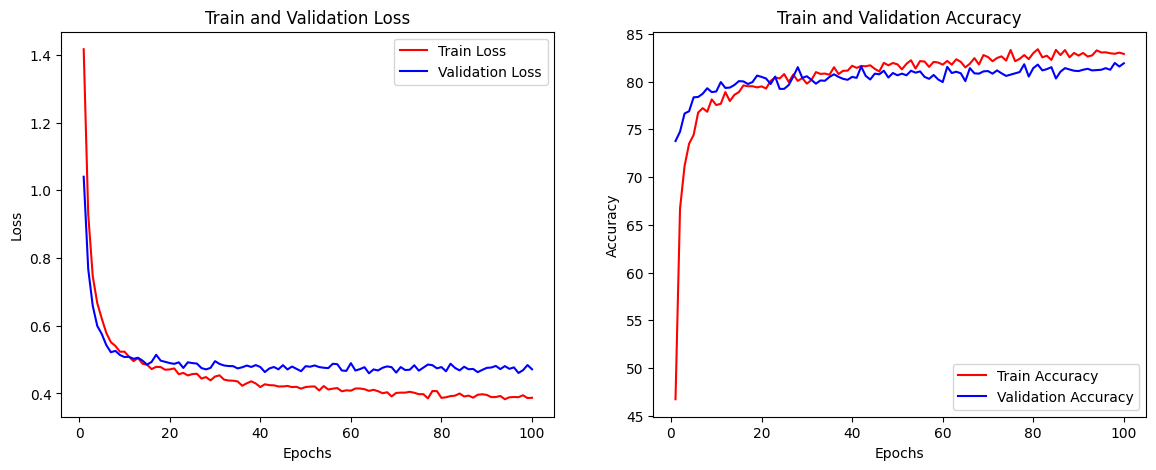

In [21]:
# Plotando a perda e a precisão do modelo sem augmentation
epocas = range(1, epochs + 1) # é 36 epocas porque com early stopping so rodou 36 epocas

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epocas, train_losses, 'r', label='Train Loss')
plt.plot(epocas, val_losses, 'b', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epocas, train_accuracies, 'r', label='Train Accuracy')
plt.plot(epocas, val_accuracies, 'b', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [22]:
# salvando modelo
torch.save(net.state_dict(), "model/downstream_vae.pth")

In [13]:
# carregando modelo
model_path = "model/downstream_vae.pth"

# Criar uma instância do modelo
model_backbone = TemporalVAE(device, input_dim, hidden_dim, latent_dim, num_layers).to(device)
net = Net(model_backbone, input_dim=input_dim).to(device)
# Carregar o estado salvo
state_dict = torch.load(model_path)

# Carregar o estado no modelo
net.load_state_dict(state_dict)

<All keys matched successfully>

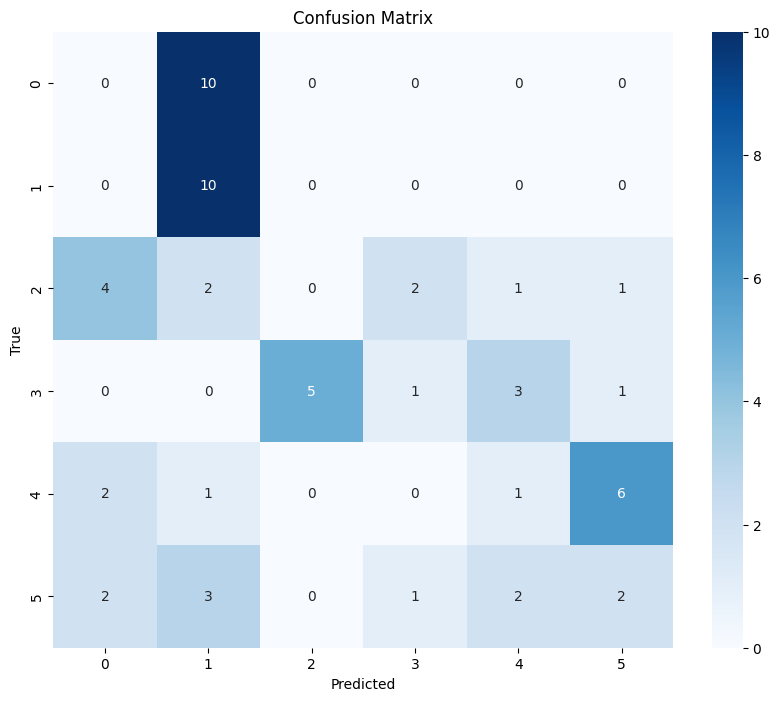

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.38      1.00      0.56        10
           2       0.00      0.00      0.00        10
           3       0.25      0.10      0.14        10
           4       0.14      0.10      0.12        10
           5       0.20      0.20      0.20        10

    accuracy                           0.23        60
   macro avg       0.16      0.23      0.17        60
weighted avg       0.16      0.23      0.17        60



In [15]:
# Obter previsões do conjunto de teste
net.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(train_loader):
        data = x.to(device)
        label = y.to(device)
        outputs = net(data)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Calcular a matriz de confusão
cm = confusion_matrix(all_labels, all_preds)

# Visualizar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Relatório de classificação
print(classification_report(all_labels, all_preds))